In [215]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
import glob
import re
import time
import seaborn as sns
import xgboost as xgb
import csv
import pickle
color = sns.color_palette()

In [216]:
RAW_DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/raw_data/'
DATA_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/'
TRAIN_DATA = RAW_DATA_PATH + 'train.csv'
TEST_DATA = RAW_DATA_PATH + 'test.csv'
MACRO_DATA = RAW_DATA_PATH + 'macro.csv'
MODELS_PATH = '/kaggle/dev/ashish/sberbank-russian-housing-market/models/'
SUBMISSIONS_PATH = '/kaggle/dev/sberbank-russian-housing-market-data/submissions/'

In [289]:
missing_df = macro_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count'] > 0]
missing_df['missing_count_perc'] = missing_df['missing_count'] / len(missing_df)
missing_df = missing_df.sort_values(['missing_count'], ascending=[False])
missing_df

,column_name,missing_count,missing_count_perc
90,provision_retail_space_modern_sqm,1754,19.274725
89,provision_retail_space_sqm,1753,19.263736
81,modern_education_share,1389,15.263736
82,old_education_build_share,1389,15.263736
92,theaters_viewers_per_1000_cap,1023,11.241758
87,hospital_beds_available_per_cap,1023,11.241758
88,hospital_bed_occupancy_per_year,1023,11.241758
28,grp_growth,1023,11.241758
94,museum_visitis_per_100_cap,1023,11.241758
96,population_reg_sports_share,1023,11.241758


In [234]:
# Prep
train_df = pd.read_csv(TRAIN_DATA, parse_dates=['timestamp'])
macro_df = pd.read_csv(MACRO_DATA, parse_dates=['timestamp'])
test_df = pd.read_csv(TEST_DATA, parse_dates=['timestamp'])

print('Train data', train_df.shape)
print('Test data', test_df.shape)
print('Macro data', macro_df.shape)

# Fix child_on_acc_pre_school column
# macro_df.loc[macro_df['child_on_acc_pre_school'] == '#!', 'child_on_acc_pre_school'] = 0 

print('Merging with macro data..')
# Merge train/test data with macro data
train_macro_df =  pd.merge(train_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(train_macro_df) == len(train_df))
test_macro_df =  pd.merge(test_df, macro_df, left_on='timestamp', right_on='timestamp', how='inner')
assert(len(test_macro_df) == len(test_df))

print('Train + Macro data', train_macro_df.shape)
print('Test + Macro data', test_macro_df.shape)

print('Fixing dtypes..')
# Fix incompatible data types between train and test data
train_macro_df['full_sq'] = train_macro_df['full_sq'].astype('float64')
test_macro_df['floor'] = test_macro_df['floor'].astype('float64')
test_macro_df['max_floor'] = test_macro_df['max_floor'].astype('float64')
test_macro_df['material'] = test_macro_df['material'].astype('float64')
test_macro_df['num_room'] = test_macro_df['num_room'].astype('float64')

train_columns = set(train_macro_df.columns)
drop_columns = ['id', 'timestamp', 'price_doc', 'child_on_acc_pre_school']

print('Encoding columns..')
for col in drop_columns:
    if col in train_columns:
        train_columns.remove(col)

for f in train_columns:
    if train_macro_df[f].dtype=='object':
        # print('encoding column:', f, '(original dtype:', train_macro_df[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_macro_df[f].values) | set(test_macro_df[f].values)))
        try:
            train_macro_df[f] = lbl.transform(list(train_macro_df[f].values))
            test_macro_df[f] = lbl.transform(list(test_macro_df[f].values))
        except TypeError as err:
            print('Error encoding column: ', f, err)

def rmsle(y_predicted, y_true):
    y_pred = y_predicted
    y_label = y_true.get_label()
    temp = np.square(np.log(y_pred + 1.0) - np.log(y_label + 1.0))
    error = np.sqrt(np.mean(temp))
    error_std = np.sqrt(np.std(temp))
    print('rmsle:', error, '; std:', error_std)
    return ("rmsle", error)

X = train_macro_df[list(train_columns)]
Y = train_macro_df.price_doc.values

train_X, val_X, train_Y, val_Y = model_selection.train_test_split(X, Y, train_size=0.7, random_state=42)

print('train_X.shape', train_X.shape)
print('train_Y.shape', train_Y.shape)
print('val_X.shape', val_X.shape)
print('val_Y.shape', val_Y.shape)

Train data (30471, 292)
Test data (7662, 291)
Macro data (2484, 100)
Merging with macro data..
Train + Macro data (30471, 391)
Test + Macro data (7662, 390)
Fixing dtypes..
Encoding columns..
train_X.shape (21329, 387)
train_Y.shape (21329,)
val_X.shape (9142, 387)
val_Y.shape (9142,)


In [235]:
model = xgb.XGBRegressor(max_depth = 10,
                        gamma=0.5,
                        objective="reg:linear",
                        n_estimators=10000,
                        learning_rate=0.005,
                        nthread=12,
                        subsample=0.8,
                        colsample_bytree=0.70,
                        colsample_bylevel=0.70,
                        seed=42,
                        silent=True)

model.fit(train_X, train_Y, eval_set=[(train_X, train_Y), (val_X, val_Y)], verbose=True, eval_metric=rmsle, early_stopping_rounds=50)

model_id = "model-" + str(int(time.time()))
pickle.dump(model, open(MODELS_PATH + model_id + ".xgb", "wb"))

print("Saved model ", model_id)

rmsle: 5.27708 ; std: 2.07792
rmsle: 5.28787 ; std: 2.3889
[0]	validation_0-rmsle:5.27708	validation_1-rmsle:5.28787
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 50 rounds.
rmsle: 4.57078 ; std: 1.83067
rmsle: 4.57356 ; std: 1.98832
[1]	validation_0-rmsle:4.57078	validation_1-rmsle:4.57356
rmsle: 4.16225 ; std: 1.73042
rmsle: 4.16197 ; std: 1.85141
[2]	validation_0-rmsle:4.16225	validation_1-rmsle:4.16197
rmsle: 3.87684 ; std: 1.65397
rmsle: 3.87694 ; std: 1.76254
[3]	validation_0-rmsle:3.87684	validation_1-rmsle:3.87694
rmsle: 3.65709 ; std: 1.59759
rmsle: 3.65774 ; std: 1.69466
[4]	validation_0-rmsle:3.65708	validation_1-rmsle:3.65774
rmsle: 3.47828 ; std: 1.54721
rmsle: 3.47933 ; std: 1.64172
[5]	validation_0-rmsle:3.47828	validation_1-rmsle:3.47933
rmsle: 3.32718 ; std: 1.50446
rmsle: 3.32906 ; std: 1.59437
[6]	validation_0-rmsle:3.32718	validation_1-rmsle:3.32906
rmsle: 3.19699

rmsle: 1.22728 ; std: 0.73461
rmsle: 1.24317 ; std: 0.777892
[68]	validation_0-rmsle:1.22728	validation_1-rmsle:1.24317
rmsle: 1.21591 ; std: 0.728559
rmsle: 1.23202 ; std: 0.7719
[69]	validation_0-rmsle:1.21591	validation_1-rmsle:1.23202
rmsle: 1.20475 ; std: 0.722511
rmsle: 1.22109 ; std: 0.766234
[70]	validation_0-rmsle:1.20475	validation_1-rmsle:1.22109
rmsle: 1.19378 ; std: 0.716536
rmsle: 1.21043 ; std: 0.760582
[71]	validation_0-rmsle:1.19378	validation_1-rmsle:1.21043
rmsle: 1.18287 ; std: 0.710882
rmsle: 1.19978 ; std: 0.755368
[72]	validation_0-rmsle:1.18287	validation_1-rmsle:1.19978
rmsle: 1.1723 ; std: 0.705184
rmsle: 1.1895 ; std: 0.750173
[73]	validation_0-rmsle:1.1723	validation_1-rmsle:1.1895
rmsle: 1.16196 ; std: 0.699629
rmsle: 1.17937 ; std: 0.744928
[74]	validation_0-rmsle:1.16196	validation_1-rmsle:1.17937
rmsle: 1.15174 ; std: 0.693991
rmsle: 1.16939 ; std: 0.739711
[75]	validation_0-rmsle:1.15174	validation_1-rmsle:1.16939
rmsle: 1.14171 ; std: 0.688487
rmsle: 1

rmsle: 0.747722 ; std: 0.501094
rmsle: 0.779785 ; std: 0.610419
[135]	validation_0-rmsle:0.747722	validation_1-rmsle:0.779785
rmsle: 0.743385 ; std: 0.500181
rmsle: 0.775723 ; std: 0.610572
[136]	validation_0-rmsle:0.743385	validation_1-rmsle:0.775723
rmsle: 0.739123 ; std: 0.499353
rmsle: 0.771707 ; std: 0.610811
[137]	validation_0-rmsle:0.739123	validation_1-rmsle:0.771707
rmsle: 0.734881 ; std: 0.498554
rmsle: 0.767763 ; std: 0.611018
[138]	validation_0-rmsle:0.734881	validation_1-rmsle:0.767763
rmsle: 0.73065 ; std: 0.497929
rmsle: 0.763766 ; std: 0.611367
[139]	validation_0-rmsle:0.73065	validation_1-rmsle:0.763766
rmsle: 0.726533 ; std: 0.497307
rmsle: 0.759912 ; std: 0.61174
[140]	validation_0-rmsle:0.726533	validation_1-rmsle:0.759912
rmsle: 0.722454 ; std: 0.496667
rmsle: 0.75609 ; std: 0.612101
[141]	validation_0-rmsle:0.722454	validation_1-rmsle:0.75609
rmsle: 0.71843 ; std: 0.49633
rmsle: 0.752301 ; std: 0.612777
[142]	validation_0-rmsle:0.71843	validation_1-rmsle:0.752301


rmsle: 0.546072 ; std: 0.528237
rmsle: 0.595643 ; std: 0.670344
[201]	validation_0-rmsle:0.546072	validation_1-rmsle:0.595643
rmsle: 0.54403 ; std: 0.529262
rmsle: 0.593852 ; std: 0.671492
[202]	validation_0-rmsle:0.54403	validation_1-rmsle:0.593852
rmsle: 0.542009 ; std: 0.530229
rmsle: 0.592115 ; std: 0.672661
[203]	validation_0-rmsle:0.542009	validation_1-rmsle:0.592115
rmsle: 0.539999 ; std: 0.531163
rmsle: 0.590397 ; std: 0.673801
[204]	validation_0-rmsle:0.539999	validation_1-rmsle:0.590397
rmsle: 0.53802 ; std: 0.532164
rmsle: 0.588685 ; std: 0.674915
[205]	validation_0-rmsle:0.53802	validation_1-rmsle:0.588685
rmsle: 0.536062 ; std: 0.533126
rmsle: 0.586984 ; std: 0.676007
[206]	validation_0-rmsle:0.536062	validation_1-rmsle:0.586984
rmsle: 0.534136 ; std: 0.534132
rmsle: 0.585292 ; std: 0.677061
[207]	validation_0-rmsle:0.534136	validation_1-rmsle:0.585292
rmsle: 0.53216 ; std: 0.534954
rmsle: 0.583633 ; std: 0.678123
[208]	validation_0-rmsle:0.53216	validation_1-rmsle:0.58363

rmsle: 0.449223 ; std: 0.585367
rmsle: 0.514757 ; std: 0.73519
[267]	validation_0-rmsle:0.449223	validation_1-rmsle:0.514757
rmsle: 0.448226 ; std: 0.586041
rmsle: 0.513971 ; std: 0.736005
[268]	validation_0-rmsle:0.448226	validation_1-rmsle:0.513971
rmsle: 0.447232 ; std: 0.586799
rmsle: 0.513169 ; std: 0.736802
[269]	validation_0-rmsle:0.447232	validation_1-rmsle:0.513169
rmsle: 0.44626 ; std: 0.587479
rmsle: 0.512422 ; std: 0.737586
[270]	validation_0-rmsle:0.44626	validation_1-rmsle:0.512422
rmsle: 0.445247 ; std: 0.588064
rmsle: 0.51167 ; std: 0.738393
[271]	validation_0-rmsle:0.445247	validation_1-rmsle:0.51167
rmsle: 0.444267 ; std: 0.58871
rmsle: 0.510921 ; std: 0.739175
[272]	validation_0-rmsle:0.444267	validation_1-rmsle:0.510921
rmsle: 0.443284 ; std: 0.589293
rmsle: 0.510194 ; std: 0.739965
[273]	validation_0-rmsle:0.443284	validation_1-rmsle:0.510194
rmsle: 0.442345 ; std: 0.589908
rmsle: 0.509474 ; std: 0.740738
[274]	validation_0-rmsle:0.442345	validation_1-rmsle:0.50947

rmsle: 0.401991 ; std: 0.621885
rmsle: 0.480099 ; std: 0.779552
[333]	validation_0-rmsle:0.401991	validation_1-rmsle:0.480099
rmsle: 0.401511 ; std: 0.622302
rmsle: 0.47977 ; std: 0.780022
[334]	validation_0-rmsle:0.401511	validation_1-rmsle:0.47977
rmsle: 0.40102 ; std: 0.622694
rmsle: 0.47944 ; std: 0.780551
[335]	validation_0-rmsle:0.40102	validation_1-rmsle:0.47944
rmsle: 0.400517 ; std: 0.623012
rmsle: 0.479115 ; std: 0.781073
[336]	validation_0-rmsle:0.400517	validation_1-rmsle:0.479115
rmsle: 0.400039 ; std: 0.623438
rmsle: 0.478808 ; std: 0.781612
[337]	validation_0-rmsle:0.400039	validation_1-rmsle:0.478808
rmsle: 0.399595 ; std: 0.623869
rmsle: 0.478505 ; std: 0.782143
[338]	validation_0-rmsle:0.399595	validation_1-rmsle:0.478505
rmsle: 0.399151 ; std: 0.624302
rmsle: 0.478204 ; std: 0.782661
[339]	validation_0-rmsle:0.399151	validation_1-rmsle:0.478204
rmsle: 0.398686 ; std: 0.624663
rmsle: 0.477898 ; std: 0.783158
[340]	validation_0-rmsle:0.398686	validation_1-rmsle:0.47789

rmsle: 0.378955 ; std: 0.643634
rmsle: 0.466268 ; std: 0.809077
[399]	validation_0-rmsle:0.378955	validation_1-rmsle:0.466268
rmsle: 0.378721 ; std: 0.643862
rmsle: 0.466147 ; std: 0.809459
[400]	validation_0-rmsle:0.378721	validation_1-rmsle:0.466147
rmsle: 0.378458 ; std: 0.644053
rmsle: 0.466031 ; std: 0.809841
[401]	validation_0-rmsle:0.378458	validation_1-rmsle:0.466031
rmsle: 0.378257 ; std: 0.644376
rmsle: 0.465906 ; std: 0.810192
[402]	validation_0-rmsle:0.378257	validation_1-rmsle:0.465906
rmsle: 0.378005 ; std: 0.644562
rmsle: 0.465798 ; std: 0.810563
[403]	validation_0-rmsle:0.378005	validation_1-rmsle:0.465798
rmsle: 0.377779 ; std: 0.644816
rmsle: 0.465691 ; std: 0.810964
[404]	validation_0-rmsle:0.377779	validation_1-rmsle:0.465691
rmsle: 0.377538 ; std: 0.645002
rmsle: 0.465576 ; std: 0.811315
[405]	validation_0-rmsle:0.377538	validation_1-rmsle:0.465576
rmsle: 0.377337 ; std: 0.645299
rmsle: 0.465477 ; std: 0.811687
[406]	validation_0-rmsle:0.377337	validation_1-rmsle:0

rmsle: 0.366974 ; std: 0.655452
rmsle: 0.461526 ; std: 0.829408
[465]	validation_0-rmsle:0.366974	validation_1-rmsle:0.461526
rmsle: 0.366819 ; std: 0.65552
rmsle: 0.461488 ; std: 0.829656
[466]	validation_0-rmsle:0.366819	validation_1-rmsle:0.461488
rmsle: 0.366675 ; std: 0.655619
rmsle: 0.461452 ; std: 0.829872
[467]	validation_0-rmsle:0.366675	validation_1-rmsle:0.461452
rmsle: 0.366582 ; std: 0.655799
rmsle: 0.46142 ; std: 0.830123
[468]	validation_0-rmsle:0.366582	validation_1-rmsle:0.46142
rmsle: 0.366441 ; std: 0.65589
rmsle: 0.461392 ; std: 0.83037
[469]	validation_0-rmsle:0.366441	validation_1-rmsle:0.461392
rmsle: 0.366371 ; std: 0.656126
rmsle: 0.461361 ; std: 0.830629
[470]	validation_0-rmsle:0.366371	validation_1-rmsle:0.461361
rmsle: 0.366242 ; std: 0.656245
rmsle: 0.461325 ; std: 0.830863
[471]	validation_0-rmsle:0.366242	validation_1-rmsle:0.461325
rmsle: 0.366064 ; std: 0.656252
rmsle: 0.461301 ; std: 0.831118
[472]	validation_0-rmsle:0.366064	validation_1-rmsle:0.4613

rmsle: 0.359794 ; std: 0.660691
rmsle: 0.460492 ; std: 0.843435
[531]	validation_0-rmsle:0.359794	validation_1-rmsle:0.460492
rmsle: 0.359704 ; std: 0.660733
rmsle: 0.460496 ; std: 0.843607
[532]	validation_0-rmsle:0.359704	validation_1-rmsle:0.460496
rmsle: 0.359575 ; std: 0.660695
rmsle: 0.460491 ; std: 0.843783
[533]	validation_0-rmsle:0.359575	validation_1-rmsle:0.460491
rmsle: 0.359478 ; std: 0.660731
rmsle: 0.460485 ; std: 0.843952
[534]	validation_0-rmsle:0.359478	validation_1-rmsle:0.460485
rmsle: 0.359421 ; std: 0.660807
rmsle: 0.460478 ; std: 0.844111
[535]	validation_0-rmsle:0.359421	validation_1-rmsle:0.460478
rmsle: 0.359326 ; std: 0.660814
rmsle: 0.460476 ; std: 0.844305
[536]	validation_0-rmsle:0.359326	validation_1-rmsle:0.460476
rmsle: 0.359238 ; std: 0.66085
rmsle: 0.460467 ; std: 0.844456
[537]	validation_0-rmsle:0.359238	validation_1-rmsle:0.460467
rmsle: 0.359179 ; std: 0.66095
rmsle: 0.460474 ; std: 0.844647
[538]	validation_0-rmsle:0.359179	validation_1-rmsle:0.4

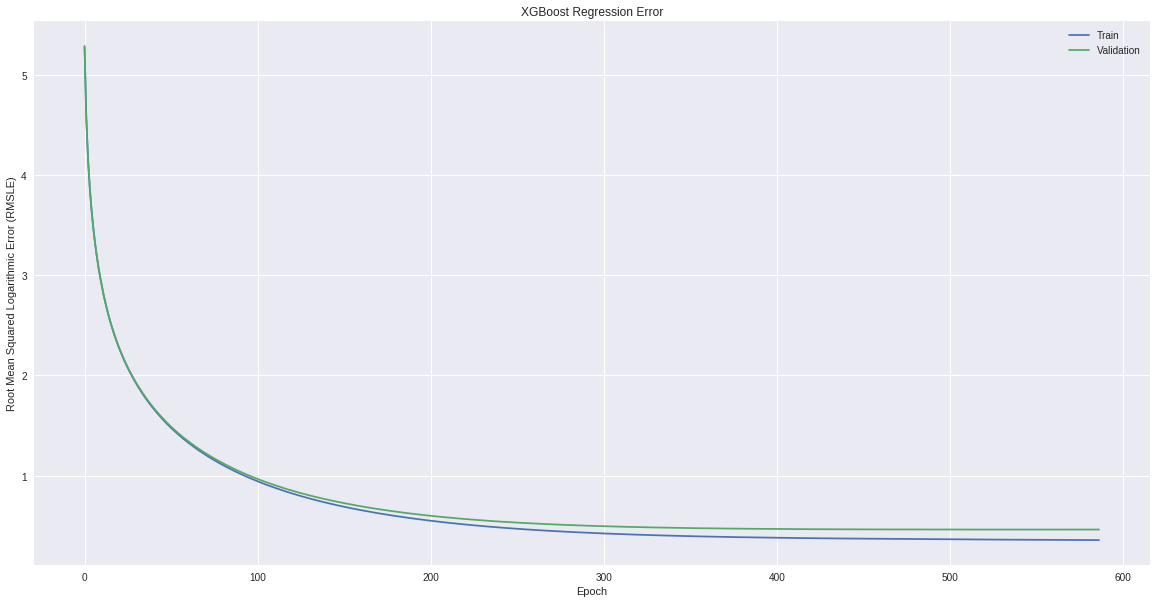

In [237]:
results = model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Validation')
ax.legend()
plt.ylabel('Root Mean Squared Logarithmic Error (RMSLE)')
plt.xlabel('Epoch')
plt.title('XGBoost Regression Error')
plt.show()

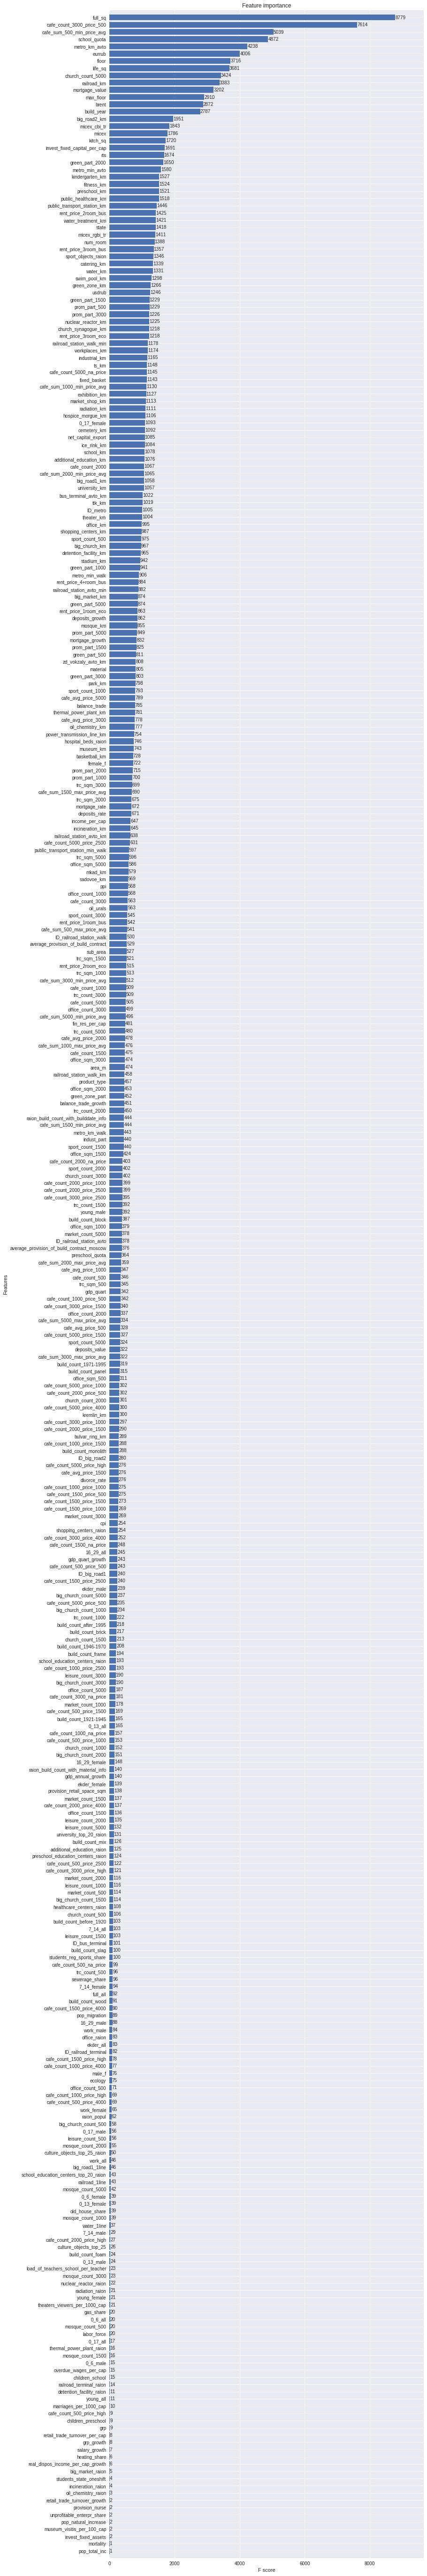

In [238]:
fig, ax = plt.subplots(figsize=(12,100))
xgb.plot_importance(model, height=0.8, ax=ax)

In [290]:
feature_importances_df = pd.DataFrame.from_dict(model.booster().get_score(), orient="index").reset_index()
feature_importances_df.columns = ['feature_name', 'importance_score']
feature_importances_df = feature_importances_df.sort_values(['importance_score'], ascending=[False])
feature_importances_df

,feature_name,importance_score
304,full_sq,8779
6,cafe_count_3000_price_500,7614
175,cafe_sum_500_min_price_avg,5039
7,school_quota,4872
9,metro_km_avto,4238
20,eurrub,4006
61,floor,3716
347,life_sq,3681
8,church_count_5000,3424
18,railroad_km,3383


In [291]:
macro_importance_df = pd.merge(feature_importances_df, missing_df, left_on='feature_name', right_on='column_name', how='inner')
macro_importance_df

,feature_name,importance_score,column_name,missing_count,missing_count_perc
0,eurrub,4006,eurrub,3,0.032967
1,brent,2872,brent,3,0.032967
2,micex_cbi_tr,1843,micex_cbi_tr,1,0.010989
3,micex,1786,micex,10,0.109890
4,invest_fixed_capital_per_cap,1691,invest_fixed_capital_per_cap,293,3.219780
5,rts,1674,rts,10,0.109890
6,rent_price_2room_bus,1425,rent_price_2room_bus,273,3.000000
7,micex_rgbi_tr,1411,micex_rgbi_tr,10,0.109890
8,rent_price_3room_bus,1357,rent_price_3room_bus,273,3.000000
9,usdrub,1246,usdrub,3,0.032967


In [220]:
# Create test dataframe
test_columns = list(train_columns)
test_columns.append('id')

test_X =  test_macro_df[test_columns]
print("test_X.shape", test_X.shape)

test_X.shape (7662, 388)


In [232]:
# Predict
submission_columns = ['id', 'predicted_price_doc']
model = pickle.load(open(MODELS_PATH + model_id + ".xgb", 'rb'))
filename = SUBMISSIONS_PATH + 'submission-' + str(int(time.time())) + ".csv"
test_X = test_X.assign(predicted_price_doc=model.predict(test_X.loc[:, train_columns]))
predicted_submission_df = test_X[submission_columns]
predicted_submission_df.columns = ['id', 'price_doc']
predicted_submission_df.to_csv(filename, index=False)
print('Generated submission file: {}'.format(filename))

Generated submission file: /kaggle/dev/sberbank-russian-housing-market-data/submissions/submission-1495444828.csv
